In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import norm
import time
from ipywidgets import interact, FloatSlider

# SVJ model

 $$
  dS_t = (r - q - \lambda \kappa_J)S_t dt + \sqrt{v_t}S_t dW^1_t + (J - 1)dNt\\
  dv_t = \kappa(\theta - v_t)dt + \xi\sqrt{v_t}dW^2_t \\
  dW^1_t dW^2_t = \rho dt
 $$

 - Nt: Poisson with intensity $\lambda$
 - J = $e^{Y}$, where Y ~ $N(\mu_j, \sigma_J^{2})$
 - $\kappa_j$ : E[J - 1] = $e^{\mu_j + \frac{1}{2}\sigma_J^{2}}$ - 1

In [8]:
@dataclass
class SVJparams:
    kappa : float # reversion rate
    sigma: float # vol of vol
    theta : float # long term variance
    v0 : float # initial variance
    rho : float # corr coef of Brownian motion
    lamda: float # intensity of Poisson
    mu_j: float # mean of jump
    sigma_j: float # vol of jump

In [9]:
def SVJ_cf_log_ST(u, T, S0, r, q, p: SVJparams):
    i = 1j
    x0 = np.log(S0)
    a  = p.kappa * p.theta
    b  = p.kappa - p.rho * p.sigma * i * u
    d  = np.sqrt(b*b + (p.sigma**2) * (i*u + u*u))
    g  = (b - d) / (b + d)
    lamdakj = p.lamda * np.exp(p.mu_j + 0.5 * p.sigma_j) - 1

    eDT = np.exp(-d * T)
    one_minus_g_eDT = 1 - g * eDT
    one_minus_g     = 1 - g
    # small guards
    one_minus_g_eDT = np.where(np.abs(one_minus_g_eDT) < 1e-15, 1e-15, one_minus_g_eDT)
    one_minus_g     = np.where(np.abs(one_minus_g)     < 1e-15, 1e-15, one_minus_g)

    # jump cf
    G = np.exp((p.lamda * T) * (np.exp(i * u * p.mu_j - 0.5 * p.sigma_j ** 2 * u ** 2) - 1))

    C = i*u*(r - q - lamdakj)*T + (a/(p.sigma**2)) * ((b - d)*T - 2.0*np.log(one_minus_g_eDT/one_minus_g))
    D = ((b - d)/(p.sigma**2)) * ((1 - eDT) / one_minus_g_eDT)
    return np.exp(C + D*p.v0 + i*u*x0) * G

In [10]:

def simpson_weights(N: int):
    if N % 2 != 0:
        raise ValueError("N must be even")
    w = np.ones(N)
    w[1:N-1:2] = 4
    w[2:N-2:2] = 2
    return w

# alpha dampening factor
# eta is step in frequency domain

def svj_fft_calls(S0:float, T:float, r:float, q:float, p:SVJparams, N:int = 2**14, eta:float = 0.1, alpha:float = 1.5):
    n = np.arange(N)
    v = eta * n   
    i = 1j
    phi_shift = SVJ_cf_log_ST(v - (alpha + 1)*i, S0, T , r, q, p)        
    denom = (alpha ** 2 + alpha  - v ** 2 + i*(2*alpha + 1)* v)  
    psi = np.exp(-r * T) * phi_shift/denom

    w = simpson_weights(N) * (eta / 3.0)

    # FFT coupling
    lam  = 2.0 * np.pi / (N * eta)   # Δk (log-strike step)
    b = 0.5 * N * lam     # half-width in k
    x   = psi * np.exp(1j * b * v) * w

    F  = np.fft.fft(x)
    F  = np.real(F)

    j = np.arange(N)
    k = -b + j * lam                 # k = ln K
    K = np.exp(k)

    calls = np.exp(-alpha * k) / np.pi * F
    order = np.argsort(K)
    return K[order], np.maximum(calls[order], 0.0)


def svj_fft_call_price(S0: float, K: float, T: float, r: float, q: float, p: SVJparams,
    N: int = 2**14, eta: float = 0.1, alpha: float = 1.5):
    K_grid, C_grid = svj_fft_calls(S0, T, r, q, p, N=N, eta=eta, alpha=alpha)
    if K <= K_grid[0]:
        return C_grid[0]
    if K >= K_grid[-1]:
        return C_grid[-1]
    idx = np.searchsorted(K_grid, K)
    x0, x1 = K_grid[idx-1], K_grid[idx]
    y0, y1 = C_grid[idx-1], C_grid[idx]
    return y0 + (y1 - y0) * (K - x0) / (x1 - x0)

def svj_fft_put_price(
    S0: float, K: float, T: float, r: float, q: float, p: SVJparams,
    N: int = 2**14, eta: float = 0.1, alpha: float = 1.5
):
    """Put via put–call parity."""
    C = svj_fft_call_price(S0, K, T, r, q, p, N=N, eta=eta, alpha=alpha)
    return C - S0*np.exp(-q*T) + K*np.exp(-r*T)

In [11]:
def European_Call(S0, K, T, r , sigma):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return  S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_vega(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S0 * norm.pdf(d1) * np.sqrt(T)

def get_implied_vol(market_price, S0, K, T, r, max_iter = 200, tolerance = 1e-05):
    sigma = 0.3
    for _ in range(max_iter):
        bs_price = European_Call(S0, K, T, r, sigma)
        diff = bs_price - market_price
        if abs(diff) < tolerance:
            return sigma
        vega = bs_vega(S0,K,T,r,sigma)
        if vega == 0:
            return None
        sigma -= diff/vega
    return None

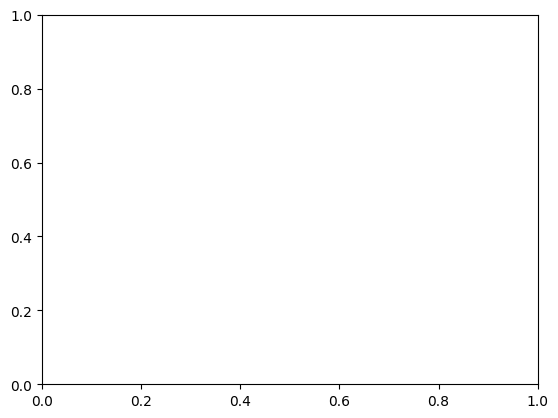

interactive(children=(FloatSlider(value=100.0, description='S0', max=300.0, min=20.0, step=1.0), FloatSlider(v…

<function __main__.plot_BS_implied_vol(S0, T, r, q, kappa, sigma, theta, v0, rho, lamda, mu_j, sigma_j, K_min=60, K_max=300)>

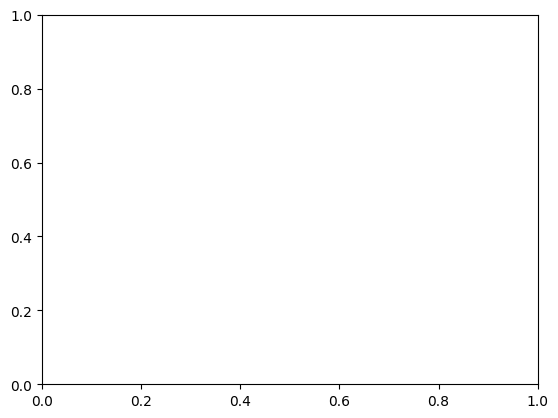

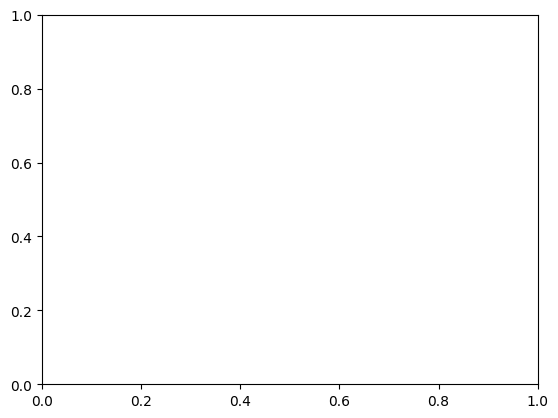

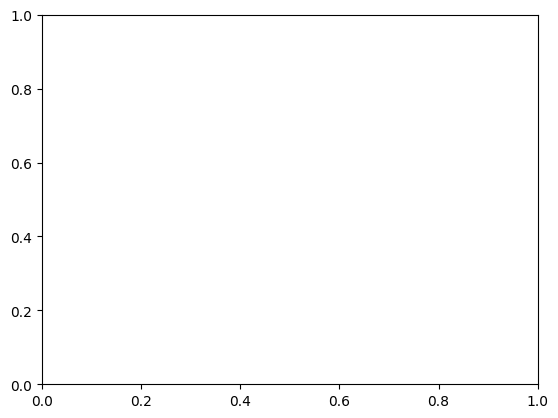

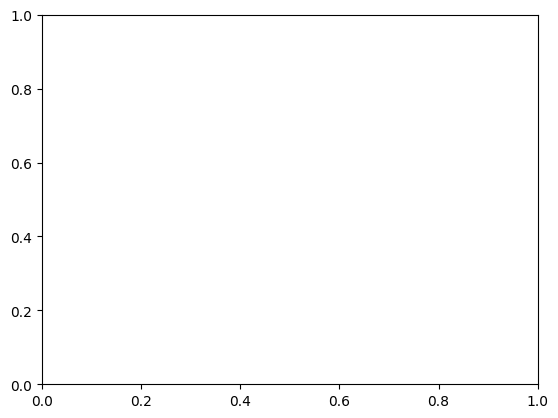

In [12]:
def plot_BS_implied_vol(S0, T, r, q, kappa, sigma, theta, v0, rho, lamda, mu_j, sigma_j, K_min = 60, K_max = 300):
    fig, ax = plt.subplots()
    
    hp = SVJparams(kappa = kappa, sigma = sigma, theta = theta, v0 = v0, rho = rho, lamda = lamda, mu_j = mu_j, sigma_j = sigma_j)
    moneyness_grid = np.log(np.linspace(K_min , K_max, 300)/(S0 * np.exp(r * T)))
    K_grid = np.linspace(K_min, K_max, 300)
   
    
    svj_prices = [svj_fft_call_price(S0, k, T, r , q, hp) for k in K_grid]
    BS_implied_vols = [get_implied_vol(svj_price, S0, strike, T, r) * 100 for strike, svj_price in zip(K_grid,svj_prices)] 
    ax.scatter(moneyness_grid, BS_implied_vols, marker = "x", color = 'black')
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("BS implied volatility (%)")
    ax.set_title("BS implied volatility(%) for Heston model")
    ax.grid(True)
    plt.show()

interact(plot_BS_implied_vol,
         S0=FloatSlider(value=100, min=20,  max=300, step=1,   description="S0"),
         T=FloatSlider(value=1.0, min=0.05, max=5.0, step=0.05, description="T"),
         r=FloatSlider(value=0.02, min=0.0, max=0.1, step=0.002, description="r"),
         q=FloatSlider(value=0.0, min=0.0, max=0.1, step=0.002, description="q"),
         kappa=FloatSlider(value=1.5, min=0.1, max=10.0, step=0.1, description="kappa"),
         sigma=FloatSlider(value=0.12, min=0.001, max=0.5, step=0.005, description="sigma"),
         theta=FloatSlider(value=0.01, min=0.01, max=2.0, step=0.01, description="theta"),
         v0=FloatSlider(value=0.1, min=0, max=0.3, step=0.01, description="v0"),
         rho=FloatSlider(value=0.00, min=-1.00, max=1.00, step=0.005, description="rho"),
         lamda=FloatSlider(value=0.00, min=0.00, max=4.00, step=0.005, description="lamda"),
         mu_j = FloatSlider(value=0.00, min=-4.00, max=4.00, step=0.005, description="mu_j"),
         sigma_j = FloatSlider(value = 0.00, min = 0.00, max = 2.00, step = 0.005, description = "sigma_j")
         )

